**First of all, credits to:  https://www.kaggle.com/the1owl/playing-in-the-sandbox**

**What additional stuff this notebook offers:**
* Visualizing a single decision tree
* Variable Importances
* Train based on Variable Importance

NOTE: Training using only what random forest considers as important feature variables did give a better accuracy on train set and I also did advance 25 places in the competition.

**Loading Libraries and Data**

In [1]:
import numpy as np
import pandas as pd
import sklearn
import nltk
import datetime

In [2]:
train_df = pd.read_csv("../input/sales_train.csv")
test_df = pd.read_csv("../input/test.csv")
submission_df = pd.read_csv("../input/sample_submission.csv")
items_df = pd.read_csv("../input/items.csv")
item_categories_df = pd.read_csv("../input/item_categories.csv")
shops_df = pd.read_csv("../input/shops.csv")

In [3]:
print("Shape of train data : {}, Shape of test data : {}".format(train_df.shape, test_df.shape))

Shape of train data : (2935849, 6), Shape of test data : (214200, 3)


**Difference between train and test sets**

In [4]:
[a for a in train_df.columns if a not in test_df]

['date', 'date_block_num', 'item_price', 'item_cnt_day']

In [5]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


**Adding Features**

* Text Features
* Date Features (Not necessarily needed for monthly summary but may help if using daily preds)

**Text features for items_df**

In [7]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
items_df.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [9]:
feature_count = 25
items_df['item_name_length'] = items_df['item_name'].map(lambda x : len(x)) #Length of each item_name(including punctuation in the item_name)
items_df['item_name_word_count'] = items_df['item_name'].map(lambda x : len(x.split(' '))) #Number of words/group of characters seperated by a whitespace
tfidf = sklearn.feature_extraction.text.TfidfVectorizer(max_features=feature_count) #tfidf = term frequency inverse document frequency
items_df_item_name_text_features = pd.DataFrame(tfidf.fit_transform(items_df['item_name']).toarray())
print("Shape of items_df_item_name_text_features : {}".format(items_df_item_name_text_features.shape))
cols = items_df_item_name_text_features.columns
for idx in range(feature_count):
    items_df['item_name_tfidf_' + str(idx)] = items_df_item_name_text_features[cols[idx]]
items_df.head()

Shape of items_df_item_name_text_features : (22170, 25)


,item_name,item_id,item_category_id,item_name_length,item_name_word_count,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,41,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,68,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.637898,0.0,0.0,0.0,0.0,0.442678,0.0,0.0,0.0,0.403761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.483839
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,45,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,47,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,***КОРОБКА (СТЕКЛО) D,4,40,43,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


**Text features for item_categories_df**

In [10]:
item_categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [11]:
item_categories_df.describe()

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


In [12]:
feature_count = 25
item_categories_df['item_categories_name_length'] = item_categories_df['item_category_name'].map(lambda x : len(x)) #Length of each item_category_name(including punctuation in the item_category_name)
item_categories_df['item_categories_name_word_count'] = item_categories_df['item_category_name'].map(lambda x : len(x.split(' '))) #Number of words/group of characters seperated by a whitespace
tfidf = sklearn.feature_extraction.text.TfidfVectorizer(max_features=feature_count) #tfidf = term frequency inverse document frequency
item_categories_df_item_category_name_text_features = pd.DataFrame(tfidf.fit_transform(item_categories_df['item_category_name']).toarray())
cols = item_categories_df_item_category_name_text_features.columns
for idx in range(feature_count):
    item_categories_df['item_category_name_tfidf_' + str(idx)] = item_categories_df_item_category_name_text_features[cols[idx]]
item_categories_df.head()

,item_category_name,item_category_id,item_categories_name_length,item_categories_name_word_count,item_category_name_tfidf_0,item_category_name_tfidf_1,item_category_name_tfidf_2,item_category_name_tfidf_3,item_category_name_tfidf_4,item_category_name_tfidf_5,item_category_name_tfidf_6,item_category_name_tfidf_7,item_category_name_tfidf_8,item_category_name_tfidf_9,item_category_name_tfidf_10,item_category_name_tfidf_11,item_category_name_tfidf_12,item_category_name_tfidf_13,item_category_name_tfidf_14,item_category_name_tfidf_15,item_category_name_tfidf_16,item_category_name_tfidf_17,item_category_name_tfidf_18,item_category_name_tfidf_19,item_category_name_tfidf_20,item_category_name_tfidf_21,item_category_name_tfidf_22,item_category_name_tfidf_23,item_category_name_tfidf_24
0,PC - Гарнитуры/Наушники,0,23,3,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Аксессуары - PS2,1,16,3,0.0,0.0,0.0,0.0,0.780837,0.000000,0.000000,0.000000,0.0,0.0,0.624735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Аксессуары - PS3,2,16,3,0.0,0.0,0.0,0.0,0.000000,0.780837,0.000000,0.000000,0.0,0.0,0.624735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Аксессуары - PS4,3,16,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.780837,0.000000,0.0,0.0,0.624735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Аксессуары - PSP,4,16,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.780837,0.0,0.0,0.624735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Text features for shops_df**

In [13]:
shops_df.tail()

,shop_name,shop_id
55,Цифровой склад 1С-Онлайн,55
56,"Чехов ТРЦ ""Карнавал""",56
57,"Якутск Орджоникидзе, 56",57
58,"Якутск ТЦ ""Центральный""",58
59,"Ярославль ТЦ ""Альтаир""",59


In [14]:
shops_df.describe()

,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


In [15]:
feature_count = 25
shops_df['shop_name_length'] = shops_df['shop_name'].map(lambda x : len(x)) #Length of each shop_name(including punctuation in the shop_name)
shops_df['shop_name_word_count'] = shops_df['shop_name'].map(lambda x : len(x.split(' '))) #Number of words/group of characters seperated by a whitespace
tfidf = sklearn.feature_extraction.text.TfidfVectorizer(max_features=feature_count) #tfidf = term frequency inverse document frequency
shops_df_shop_name_text_features = pd.DataFrame(tfidf.fit_transform(shops_df['shop_name']).toarray())
cols = shops_df_shop_name_text_features.columns
for idx in range(feature_count):
    shops_df['shop_name_tfidf_' + str(idx)] = shops_df_shop_name_text_features[cols[idx]]
shops_df.head()

,shop_name,shop_id,shop_name_length,shop_name_word_count,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,shop_name_tfidf_6,shop_name_tfidf_7,shop_name_tfidf_8,shop_name_tfidf_9,shop_name_tfidf_10,shop_name_tfidf_11,shop_name_tfidf_12,shop_name_tfidf_13,shop_name_tfidf_14,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,"!Якутск Орджоникидзе, 56 фран",0,29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000
1,"!Якутск ТЦ ""Центральный"" фран",1,29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.322815,0.0,0.689588,0.648274
2,"Адыгея ТЦ ""Мега""",2,16,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866844,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.498580,0.0,0.000000,0.000000
3,"Балашиха ТРК ""Октябрь-Киномир""",3,30,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000
4,"Волжский ТЦ ""Волга Молл""",4,24,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.905675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.423972,0.0,0.000000,0.000000


In [16]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [17]:
#turn data into monthly data
train_df['date'] = pd.to_datetime(train_df['date'], format='%d.%m.%Y')
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year
train_df = train_df.drop(['date', 'item_price'], axis=1)
train_df = train_df.groupby([c for c in train_df.columns if c not in ['item_cnt_day']], as_index=False)[['item_cnt_day']].sum()
train_df = train_df.rename(columns={'item_cnt_day':'item_cnt_month'})

#Monthly mean
shop_item_monthly_mean = train_df[['shop_id', 'item_id', 'item_cnt_month']].groupby(['shop_id', 'item_id'], as_index=False)[['item_cnt_month']].mean()
shop_item_monthly_mean = shop_item_monthly_mean.rename(columns={'item_cnt_month':'item_cnt_month_mean'})

#Add Mean Features
train_df = pd.merge(train_df, shop_item_monthly_mean, how='left', on=['shop_id', 'item_id'])
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean
0,0,0,32,1,2013,6.0,8.0
1,0,0,33,1,2013,3.0,3.0
2,0,0,35,1,2013,1.0,7.5
3,0,0,43,1,2013,1.0,1.0
4,0,0,51,1,2013,2.0,2.5


In [18]:
#Last Month : Oct 2015
shop_item_prev_month = train_df[train_df['date_block_num'] == 33][['shop_id', 'item_id', 'item_cnt_month']]
shop_item_prev_month = shop_item_prev_month.rename(columns={'item_cnt_month':'item_cnt_prev_month'})
shop_item_prev_month.head()

,shop_id,item_id,item_cnt_prev_month
1577593,2,31,1.0
1577594,2,486,3.0
1577595,2,787,1.0
1577596,2,794,1.0
1577597,2,968,1.0


In [19]:
#Add the above previous month features
train_df = pd.merge(train_df, shop_item_prev_month, how='left', on=['shop_id', 'item_id'])
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month
0,0,0,32,1,2013,6.0,8.0,NaN
1,0,0,33,1,2013,3.0,3.0,NaN
2,0,0,35,1,2013,1.0,7.5,NaN
3,0,0,43,1,2013,1.0,1.0,NaN
4,0,0,51,1,2013,2.0,2.5,NaN


In [20]:
np.where(pd.isnull(train_df))

(array([      0,       1,       2, ..., 1577586, 1577587, 1577592]),
 array([7, 7, 7, ..., 7, 7, 7]))

In [21]:
train_df = train_df.fillna(0.)
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month
0,0,0,32,1,2013,6.0,8.0,0.0
1,0,0,33,1,2013,3.0,3.0,0.0
2,0,0,35,1,2013,1.0,7.5,0.0
3,0,0,43,1,2013,1.0,1.0,0.0
4,0,0,51,1,2013,2.0,2.5,0.0


In [22]:
#Add Item, Category and Shop features
train_df = pd.merge(train_df, items_df, how='left', on='item_id')
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_name_length,item_name_word_count,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24
0,0,0,32,1,2013,6.0,8.0,0.0,1+1,40,3,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,33,1,2013,3.0,3.0,0.0,1+1 (BD),37,8,2,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,35,1,2013,1.0,7.5,0.0,10 ЛЕТ СПУСТЯ,40,13,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,43,1,2013,1.0,1.0,0.0,100 МИЛЛИОНОВ ЕВРО,40,18,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,51,1,2013,2.0,2.5,0.0,100 лучших произведений классики (mp3-CD) (Dig...,57,52,6,0.0,0.0,0.0,0.0,0.545735,0.621307,0.0,0.0,0.0,0.0,0.562273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
train_df = pd.merge(train_df, item_categories_df, how='left', on=['item_category_id'])
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_name_length,item_name_word_count,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24,item_category_name,item_categories_name_length,item_categories_name_word_count,item_category_name_tfidf_0,item_category_name_tfidf_1,item_category_name_tfidf_2,item_category_name_tfidf_3,item_category_name_tfidf_4,item_category_name_tfidf_5,item_category_name_tfidf_6,item_category_name_tfidf_7,item_category_name_tfidf_8,item_category_name_tfidf_9,item_category_name_tfidf_10,item_category_name_tfidf_11,item_category_name_tfidf_12,item_category_name_tfidf_13,item_category_name_tfidf_14,item_category_name_tfidf_15,item_category_name_tfidf_16,item_category_name_tfidf_17,item_category_name_tfidf_18,item_category_name_tfidf_19,item_category_name_tfidf_20,item_category_name_tfidf_21,item_category_name_tfidf_22,item_category_name_tfidf_23,item_category_name_tfidf_24
0,0,0,32,1,2013,6.0,8.0,0.0,1+1,40,3,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Кино - DVD,10,3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,33,1,2013,3.0,3.0,0.0,1+1 (BD),37,8,2,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Кино - Blu-Ray,14,3,0.0,0.603779,0.0,0.0,0.0,0.0,0.0,0.0,0.603779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.520482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,35,1,2013,1.0,7.5,0.0,10 ЛЕТ СПУСТЯ,40,13,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Кино - DVD,10,3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,43,1,2013,1.0,1.0,0.0,100 МИЛЛИОНОВ ЕВРО,40,18,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Кино - DVD,10,3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,51,1,2013,2.0,2.5,0.0,100 лучших произведений классики (mp3-CD) (Dig...,57,52,6,0.0,0.0,0.0,0.0,0.545735,0.621307,0.0,0.0,0.0,0.0,0.562273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Музыка - MP3,12,3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [24]:
train_df = pd.merge(train_df, shops_df, how='left', on=['shop_id'])
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_name_length,item_name_word_count,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24,item_category_name,item_categories_name_length,item_categories_name_word_count,...,item_category_name_tfidf_13,item_category_name_tfidf_14,item_category_name_tfidf_15,item_category_name_tfidf_16,item_category_name_tfidf_17,item_category_name_tfidf_18,item_category_name_tfidf_19,item_category_name_tfidf_20,item_category_name_tfidf_21,item_category_name_tfidf_22,item_category_name_tfidf_23,item_category_name_tfidf_24,shop_name,shop_name_length,shop_name_word_count,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,shop_name_tfidf_6,shop_name_tfidf_7,shop_name_tfidf_8,shop_name_tfidf_9,shop_name_tfidf_10,shop_name_tfidf_11,shop_name_tfidf_12,shop_name_tfidf_13,shop_name_tfidf_14,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,0,0,32,1,2013,6.0,8.0,0.0,1+1,40,3,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Кино - DVD,10,3,...,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"!Якутск Орджоникидзе, 56 фран",29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0,33,1,2013,3.0,3.0,0.0,1+1 (BD),37,8,2,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Кино - Blu-Ray,14,3,...,0.0,0.0,0.0,0.520482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"!Якутск Орджоникидзе, 56 фран",29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0,35,1,2013,1.0,7.5,0.0,10 ЛЕТ СПУСТЯ,40,13,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Кино - DVD,10,3,...,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"!Якутск Орджоникидзе, 56 фран",29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0,43,1,2013,1.0,1.0,0.0,100 МИЛЛИОНОВ ЕВРО,40,18,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Кино - DVD,10,3,...,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"!Якутск Орджоникидзе, 56 фран",29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,51,1,2013,2.0,2.5,0.0,100 лучших произведений классики (mp3-CD) (Dig...,57,52,6,0.0,0.0,0.0,0.0,0.545735,0.621307,0.0,0.0,0.0,0.0,0.562273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Музыка - MP3,12,3,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"!Якутск Орджоникидзе, 56 фран",29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
#Manipulate test data
test_df['month'] = 11
test_df['year'] = 2015
test_df['date_block_num'] = 34
test_df.head()

,ID,shop_id,item_id,month,year,date_block_num
0,0,5,5037,11,2015,34
1,1,5,5320,11,2015,34
2,2,5,5233,11,2015,34
3,3,5,5232,11,2015,34
4,4,5,5268,11,2015,34


In [26]:
#Add mean features
shop_item_monthly_mean.head()

,shop_id,item_id,item_cnt_month_mean
0,0,30,31.0
1,0,31,11.0
2,0,32,8.0
3,0,33,3.0
4,0,35,7.5


In [27]:
len(test_df)

214200

In [28]:
len(train_df)

1609124

In [29]:
test_df = pd.merge(test_df, shop_item_monthly_mean, how='left', on=['shop_id', 'item_id'])
print(len(test_df))

214200


In [30]:
test_df.head()

,ID,shop_id,item_id,month,year,date_block_num,item_cnt_month_mean
0,0,5,5037,11,2015,34,1.444444
1,1,5,5320,11,2015,34,NaN
2,2,5,5233,11,2015,34,2.000000
3,3,5,5232,11,2015,34,1.000000
4,4,5,5268,11,2015,34,NaN


In [31]:
5320 in train_df.item_id.values

False

In [32]:
5233 in train_df.item_id.values

True

In [33]:
#Add previous month features
test_df = pd.merge(test_df, shop_item_prev_month, how='left', on=['shop_id', 'item_id'])
test_df.head()

,ID,shop_id,item_id,month,year,date_block_num,item_cnt_month_mean,item_cnt_prev_month
0,0,5,5037,11,2015,34,1.444444,NaN
1,1,5,5320,11,2015,34,NaN,NaN
2,2,5,5233,11,2015,34,2.000000,1.0
3,3,5,5232,11,2015,34,1.000000,NaN
4,4,5,5268,11,2015,34,NaN,NaN


In [34]:
#Items features
test_df = pd.merge(test_df, items_df, how='left', on='item_id')
test_df.head()

,ID,shop_id,item_id,month,year,date_block_num,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_name_length,item_name_word_count,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24
0,0,5,5037,11,2015,34,1.444444,NaN,"NHL 15 [PS3, русские субтитры]",19,30,5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,1,5,5320,11,2015,34,NaN,NaN,ONE DIRECTION Made In The A.M.,55,31,7,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,2,5,5233,11,2015,34,2.000000,1.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,56,8,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.68577,0.0,0.000000,0.441193,0.0,0.0,0.0,0.0,0.578850,0.0,0.0,0.0
3,3,5,5232,11,2015,34,1.000000,NaN,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,59,9,0.0,0.588259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.554199,0.356989,0.0,0.0,0.0,0.0,0.468373,0.0,0.0,0.0
4,4,5,5268,11,2015,34,NaN,NaN,"Need for Speed [PS4, русская версия]",20,36,6,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.606187,0.0,0.0,0.0,0.0,0.795322,0.0,0.0,0.0


In [35]:
#Item Category features
test_df = pd.merge(test_df, item_categories_df, how='left', on='item_category_id')
#Shops features
test_df = pd.merge(test_df, shops_df, how='left', on='shop_id')
test_df = test_df.fillna(0.)
test_df['item_cnt_month'] = 0.
test_df.head()

,ID,shop_id,item_id,month,year,date_block_num,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_name_length,item_name_word_count,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24,item_category_name,item_categories_name_length,item_categories_name_word_count,...,item_category_name_tfidf_14,item_category_name_tfidf_15,item_category_name_tfidf_16,item_category_name_tfidf_17,item_category_name_tfidf_18,item_category_name_tfidf_19,item_category_name_tfidf_20,item_category_name_tfidf_21,item_category_name_tfidf_22,item_category_name_tfidf_23,item_category_name_tfidf_24,shop_name,shop_name_length,shop_name_word_count,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,shop_name_tfidf_6,shop_name_tfidf_7,shop_name_tfidf_8,shop_name_tfidf_9,shop_name_tfidf_10,shop_name_tfidf_11,shop_name_tfidf_12,shop_name_tfidf_13,shop_name_tfidf_14,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24,item_cnt_month
0,0,5,5037,11,2015,34,1.444444,0.0,"NHL 15 [PS3, русские субтитры]",19,30,5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,Игры - PS3,10,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Вологда ТРЦ ""Мармелад""",22,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,5,5320,11,2015,34,0.000000,0.0,ONE DIRECTION Made In The A.M.,55,31,7,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,Музыка - CD локального производства,35,5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"Вологда ТРЦ ""Мармелад""",22,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,11,2015,34,2.000000,1.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,56,8,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.68577,0.0,0.000000,0.441193,0.0,0.0,0.0,0.0,0.578850,0.0,0.0,0.0,Игры - PS3,10,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Вологда ТРЦ ""Мармелад""",22,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,5,5232,11,2015,34,1.000000,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,59,9,0.0,0.588259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.554199,0.356989,0.0,0.0,0.0,0.0,0.468373,0.0,0.0,0.0,Игры - XBOX 360,15,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Вологда ТРЦ ""Мармелад""",22,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4,5,5268,11,2015,34,0.000000,0.0,"Need for Speed [PS4, русская версия]",20,36,6,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.606187,0.0,0.0,0.0,0.0,0.795322,0.0,0.0,0.0,Игры - PS4,10,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Вологда ТРЦ ""Мармелад""",22,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


**Visualize**

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

train_test_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
print("train_df.shape = {}, test_df.shape = {}, train_test_df.shape = {}".format(train_df.shape, test_df.shape, train_test_df.shape))
stores_hm = train_test_df.pivot_table(index='shop_id', columns='item_category_id', values='item_cnt_month', aggfunc='count', fill_value=0)
print("stores_hm.shape = {}".format(stores_hm.shape))
stores_hm.tail()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """


train_df.shape = (1609124, 93), test_df.shape = (214200, 94), train_test_df.shape = (1823324, 94)
stores_hm.shape = (60, 84)


item_category_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83
shop_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
55,1,0,10,28,0,4,9,24,36,8,0,1,11,0,0,6,10,0,0,140,137,9,25,148,95,37,25,9,59,12,136,8667,0,2,87,4,11,331,109,0,...,239,35,0,149,0,84,0,0,0,0,915,672,31,108,223,0,8,151,27,131,128,91,0,89,0,94,95,1,192,19,22,44,1503,16,1692,1,3,0,0,4
56,1,0,234,229,31,123,251,62,9,8,0,95,52,5,48,90,33,6,0,1990,700,487,355,1869,267,372,2,1,1025,120,2986,277,62,106,5,117,2,3575,1049,15,...,7,238,1,227,0,179,0,0,0,0,38,6989,105,2195,645,152,27,242,382,970,564,500,1,476,0,375,439,32,653,113,1,254,61,98,49,25,9,23,53,59
57,1,0,302,281,47,148,266,117,4,8,0,94,58,5,80,123,40,17,0,2644,856,511,412,2487,395,472,2,1,1035,119,3586,277,68,90,5,126,2,6223,1375,24,...,7,135,0,217,0,152,0,0,0,0,38,9596,275,2199,659,332,60,388,609,965,1024,922,3,1163,0,602,766,30,994,164,1,977,61,151,49,20,0,14,31,85
58,1,0,218,243,41,111,246,80,1,8,0,75,52,6,47,106,38,13,0,2118,725,512,341,2230,312,399,2,1,984,114,2816,277,56,55,5,109,2,2619,720,1,...,7,35,0,184,0,120,0,0,0,0,38,6106,61,118,226,5,9,277,481,1006,875,782,0,880,0,410,502,29,893,107,1,569,61,82,49,17,0,12,33,61
59,1,0,174,199,27,54,165,73,6,8,0,86,49,9,16,66,36,2,0,1850,577,442,217,1439,258,184,2,1,1017,119,3272,277,16,68,5,122,2,2613,565,4,...,7,37,0,167,0,153,0,0,0,0,38,4413,81,132,261,18,15,212,288,938,394,363,1,571,0,300,417,32,464,102,1,369,61,20,49,20,5,0,0,110


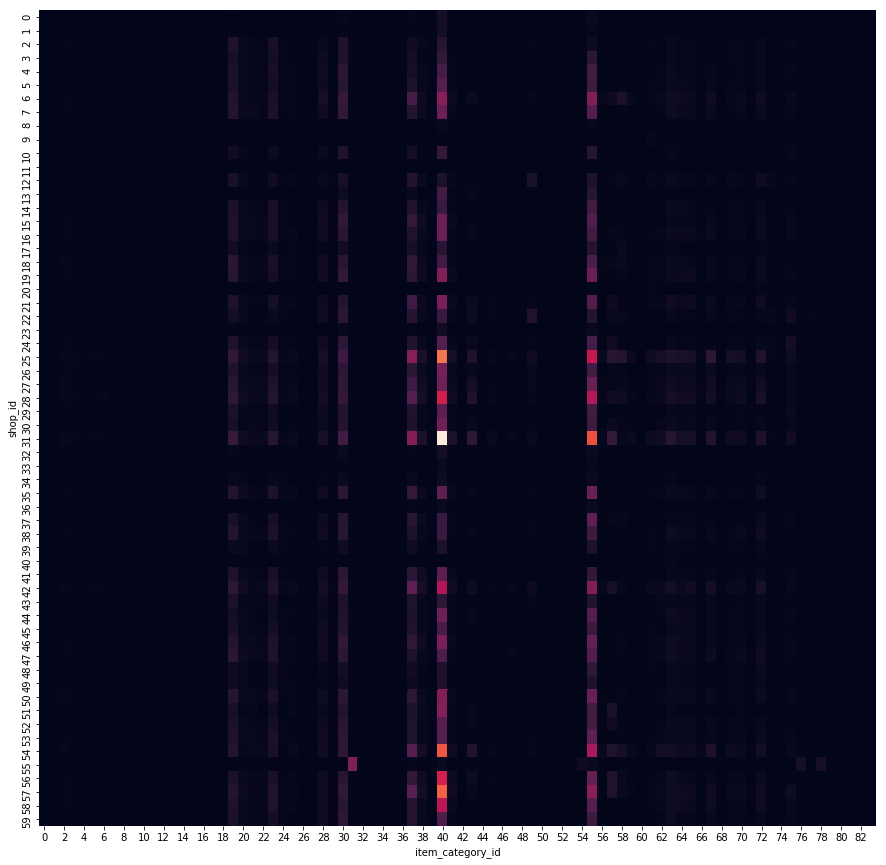

In [37]:
#Heatmap of "item_cnt_month" in "shop_id vs item_category_id" in "train_test_df"
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(stores_hm, ax=ax, cbar=False)

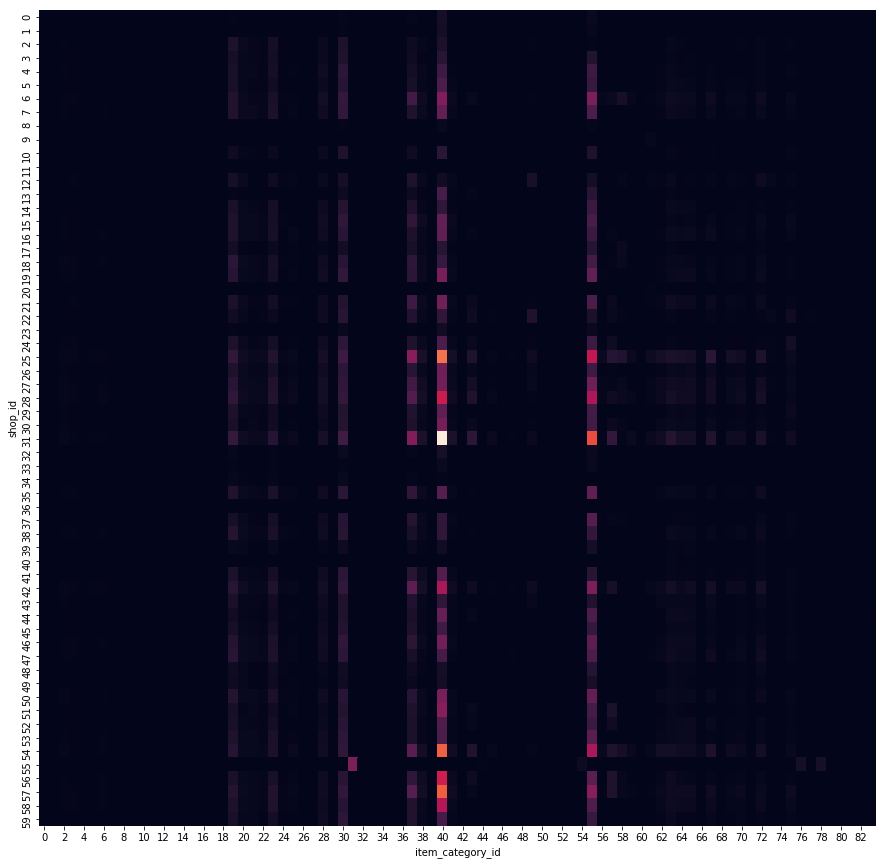

In [38]:
#Heatmap of "item_cnt_month" in "shop_id vs item_category_id" in "train_df"
stores_hm = train_df.pivot_table(index='shop_id', columns='item_category_id', values='item_cnt_month', aggfunc='count', fill_value=0)
_, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(stores_hm, ax=ax, cbar=False)

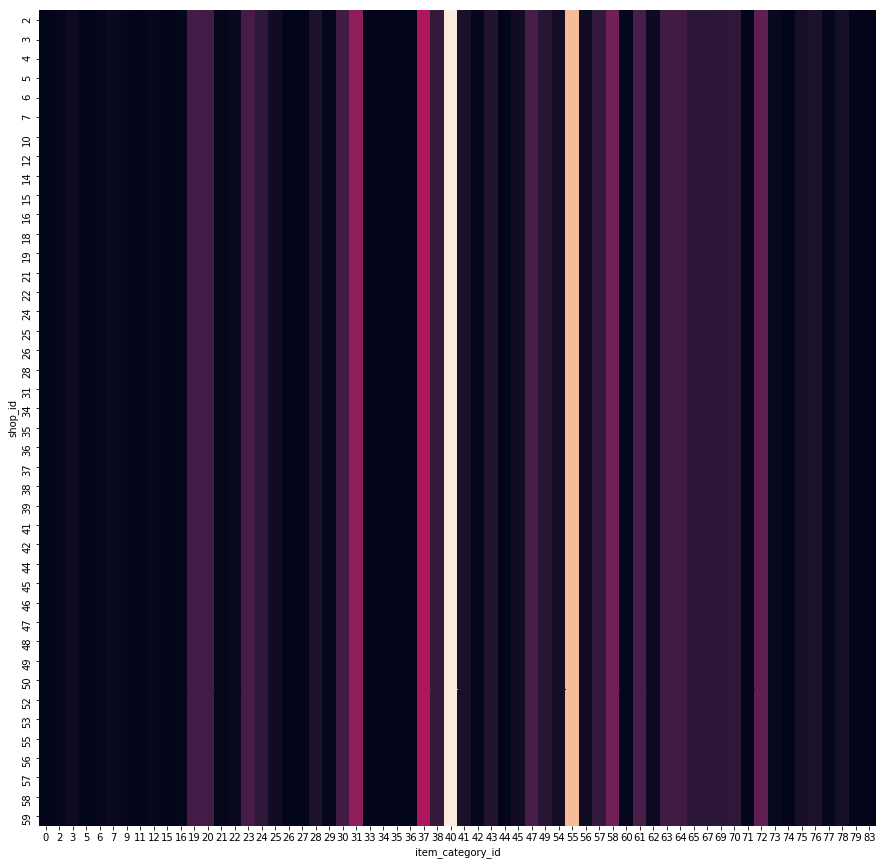

In [39]:
#Heatmap of "item_cnt_month" in "shop_id vs item_category_id" in "test_df"
stores_hm = test_df.pivot_table(index='shop_id', columns='item_category_id', values='item_cnt_month', aggfunc='count', fill_value=0)
_, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(stores_hm, ax=ax, cbar=False)

**Label Encoding**

In [40]:
for c in ['shop_name', 'item_category_name', 'item_name']:
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(list(train_df[c].unique()) + list(test_df[c].unique()))
    train_df[c] = le.transform(train_df[c].astype(str))
    test_df[c] = le.transform(test_df[c].astype(str))
    print(c)

shop_name
item_category_name
item_name


In [41]:
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_name_length,item_name_word_count,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24,item_category_name,item_categories_name_length,item_categories_name_word_count,...,item_category_name_tfidf_13,item_category_name_tfidf_14,item_category_name_tfidf_15,item_category_name_tfidf_16,item_category_name_tfidf_17,item_category_name_tfidf_18,item_category_name_tfidf_19,item_category_name_tfidf_20,item_category_name_tfidf_21,item_category_name_tfidf_22,item_category_name_tfidf_23,item_category_name_tfidf_24,shop_name,shop_name_length,shop_name_word_count,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,shop_name_tfidf_6,shop_name_tfidf_7,shop_name_tfidf_8,shop_name_tfidf_9,shop_name_tfidf_10,shop_name_tfidf_11,shop_name_tfidf_12,shop_name_tfidf_13,shop_name_tfidf_14,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,0,0,32,1,2013,6.0,8.0,0.0,32,40,3,1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,10,3,...,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0,33,1,2013,3.0,3.0,0.0,33,37,8,2,0.0,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,14,3,...,0.0,0.0,0.0,0.520482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0,35,1,2013,1.0,7.5,0.0,35,40,13,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,10,3,...,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0,43,1,2013,1.0,1.0,0.0,43,40,18,3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,10,3,...,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,51,1,2013,2.0,2.5,0.0,51,57,52,6,0.0,0.0,0.0,0.0,0.545735,0.621307,0.0,0.0,0.0,0.0,0.562273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57,12,3,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


**shop_id and labels for shop_name are the same and hence redundant. Similarly in the case of item_name and item_category_name. One in each redundant pair can be dropped.**

**These are not dropped for the time being, since variable importance takes care of it later in this notebook.**

 **Train & Predict Models**

**Reference for random forest implementation [here](https://towardsdatascience.com/random-forest-in-python-24d0893d51c0)**

In [42]:
print(train_df['shop_id'], train_df['shop_name'])
print('*'*80)
test_df.head

0           0
1           0
2           0
3           0
4           0
5           0
6           0
7           0
8           0
9           0
10          0
11          0
12          0
13          0
14          0
15          0
16          0
17          0
18          0
19          0
20          0
21          0
22          0
23          0
24          0
25          0
26          0
27          0
28          0
29          0
           ..
1609094    59
1609095    59
1609096    59
1609097    59
1609098    59
1609099    59
1609100    59
1609101    59
1609102    59
1609103    59
1609104    59
1609105    59
1609106    59
1609107    59
1609108    59
1609109    59
1609110    59
1609111    59
1609112    59
1609113    59
1609114    59
1609115    59
1609116    59
1609117    59
1609118    59
1609119    59
1609120    59
1609121    59
1609122    59
1609123    59
Name: shop_id, Length: 1609124, dtype: int64 0           0
1           0
2           0
3           0
4           0
5           0
6           0
7  

<bound method NDFrame.head of             ID  shop_id       ...        shop_name_tfidf_24  item_cnt_month
0            0        5       ...                       0.0             0.0
1            1        5       ...                       0.0             0.0
2            2        5       ...                       0.0             0.0
3            3        5       ...                       0.0             0.0
4            4        5       ...                       0.0             0.0
5            5        5       ...                       0.0             0.0
6            6        5       ...                       0.0             0.0
7            7        5       ...                       0.0             0.0
8            8        5       ...                       0.0             0.0
9            9        5       ...                       0.0             0.0
10          10        5       ...                       0.0             0.0
11          11        5       ...                       0.

In [43]:
feature_list = [c for c in train_df.columns if c not in 'item_cnt_month']
#Validation hold out month is 33
x1 = train_df[train_df['date_block_num'] < 33]
y1 = np.log1p(x1['item_cnt_month'].clip(0., 20.))
x1 = x1[feature_list]
x2 = train_df[train_df['date_block_num'] == 33]
y2 = np.log1p(x2['item_cnt_month'].clip(0., 20.))
x2 = x2[feature_list]

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=25, random_state=42, max_depth=15, n_jobs=-1)#use n_estimators=25, max_depth=15, random_state=42(for consistent results)
rf.fit(x1, y1)
print("RMSE on Validation hold out month 33: {}".format(np.sqrt(sklearn.metrics.mean_squared_error(y2.clip(0., 20.), rf.predict(x2).clip(0., 20.)))))

#Full train
rf.fit(train_df[feature_list], train_df['item_cnt_month'].clip(0., 20.))
print("Accuracy on training data without considering variable importances:{}".format(round(rf.score(train_df[feature_list], train_df['item_cnt_month'].clip(0., 20.))*100, 2)))

#predict
test_df['item_cnt_month'] = rf.predict(test_df[feature_list]).clip(0., 20.)

#create submission file
test_df[['ID', 'item_cnt_month']].to_csv('submission.csv', index=False)

RMSE on Validation hold out month 33: 0.2784118280954531
Accuracy on training data without considering variable importances:68.15


**Visualization of a single decision tree**

In [44]:
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image

In [45]:
#doesn't print. May be because its too large. Try with a smaller image.
'''tree = rf.estimators_[3]
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')
Image(filename='tree.png')'''

"tree = rf.estimators_[3]\nexport_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)\n(graph, ) = pydot.graph_from_dot_file('tree.dot')\ngraph.write_png('tree.png')\nImage(filename='tree.png')"

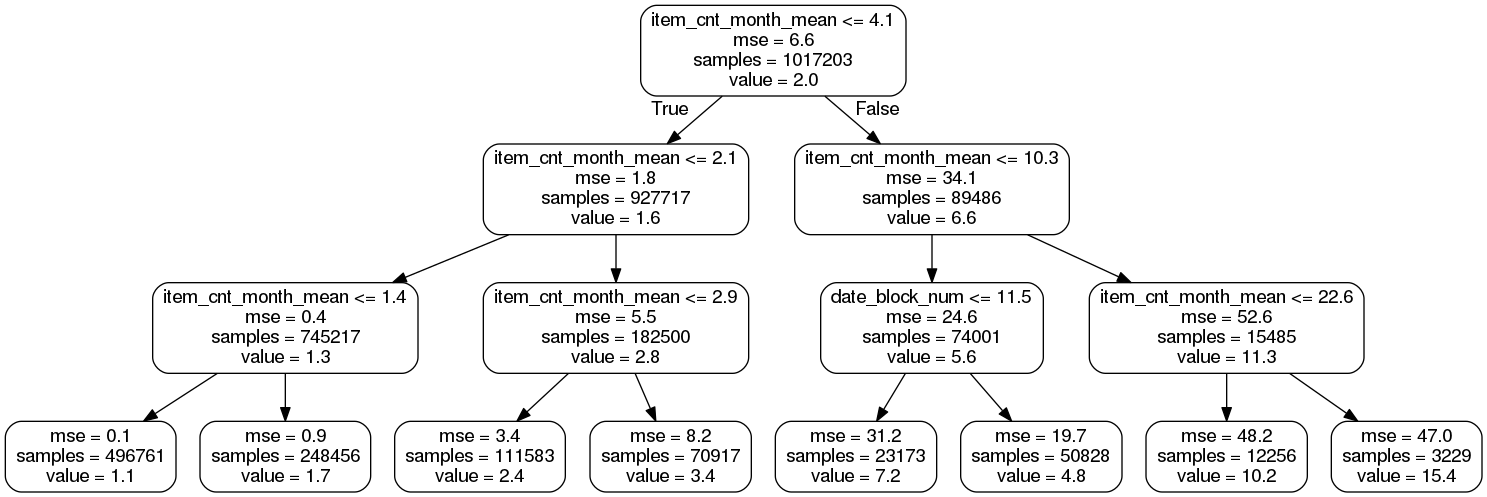

In [46]:
#To see the decision tree in action, visualizing with a smaller one for illustrative purposes
rf_small = RandomForestRegressor(n_estimators=2, random_state=42, max_depth=3, n_jobs=-1)
rf_small.fit(train_df[feature_list], train_df['item_cnt_month'].clip(0., 20.))
small_tree = rf_small.estimators_[1]
export_graphviz(small_tree, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png')
Image(filename='small_tree.png')

**Variable Importances**

**In order to quantify the usefulness of all the variables in the entire random forest, we can look at the relative importances of the variables.**

In [47]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: item_cnt_month_mean  Importance: 0.71
Variable: date_block_num       Importance: 0.09
Variable: item_cnt_prev_month  Importance: 0.03
Variable: item_id              Importance: 0.02
Variable: item_name            Importance: 0.02
Variable: item_name_length     Importance: 0.02
Variable: year                 Importance: 0.01
Variable: item_name_word_count Importance: 0.01
Variable: item_name_tfidf_21   Importance: 0.01
Variable: item_category_name_tfidf_6 Importance: 0.01
Variable: shop_id              Importance: 0.0
Variable: item_category_id     Importance: 0.0
Variable: item_name_tfidf_0    Importance: 0.0
Variable: item_name_tfidf_1    Importance: 0.0
Variable: item_name_tfidf_2    Importance: 0.0
Variable: item_name_tfidf_3    Importance: 0.0
Variable: item_name_tfidf_4    Importance: 0.0
Variable: item_name_tfidf_5    Importance: 0.0
Variable: item_name_tfidf_6    Importance: 0.0
Variable: item_name_tfidf_7    Importance: 0.0
Variable: item_name_tfidf_8    Importance: 0

**Simple bar plot of the feature importances to illustrate the disparities in the relative significance of the variables.**

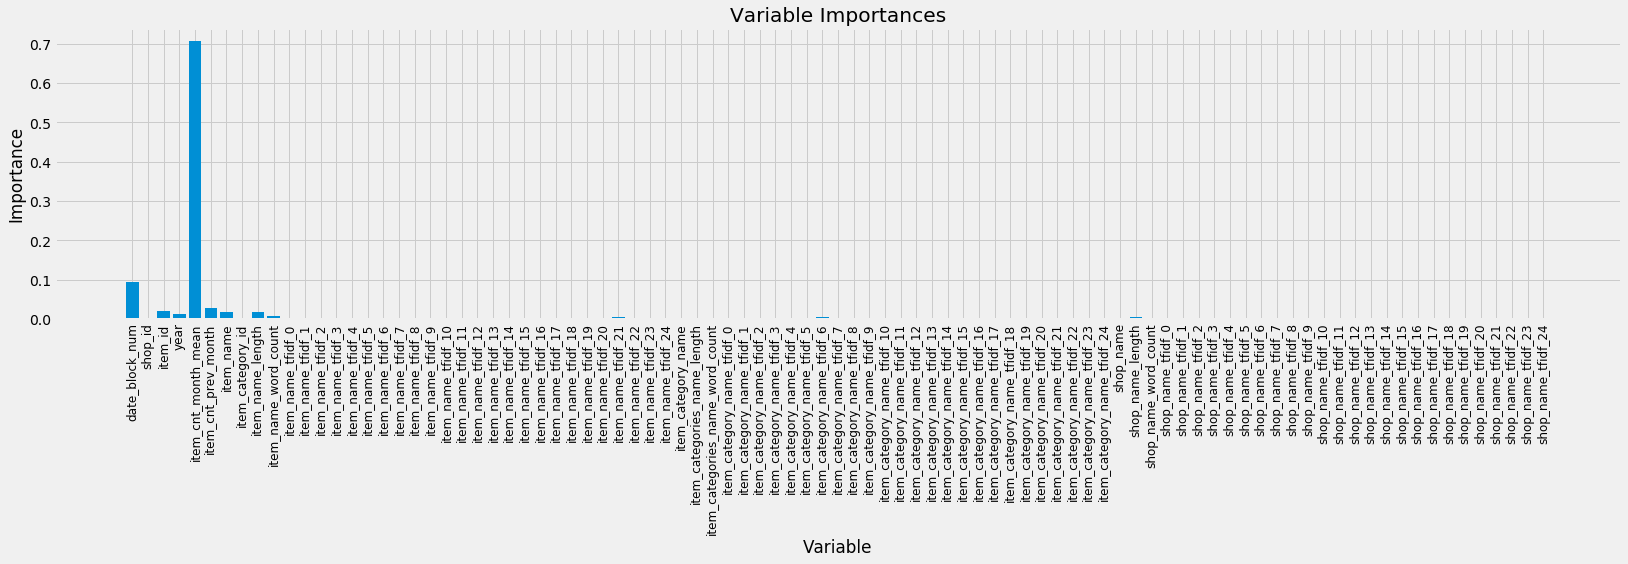

In [48]:
# Set the style
plt.style.use('fivethirtyeight')

#set size
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(111)

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
ax.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical', fontsize=12)

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

**New random forest with only ten most important variables**

In [49]:
rf_most_important = RandomForestRegressor(n_estimators=25, random_state=42, max_depth=15, n_jobs=-1)

# Extract the ten most important features
important_features = ['item_cnt_month_mean', 'date_block_num', 'item_cnt_prev_month', 'item_id', 'item_name', 'item_name_length', 'year', 'item_name_word_count', 'item_name_tfidf_21', 'item_category_name_tfidf_6']

#Full train
rf_most_important.fit(train_df[important_features], train_df['item_cnt_month'].clip(0., 20.))
print("Accuracy on training data considering variable importances:{}".format(round(rf_most_important.score(train_df[important_features], train_df['item_cnt_month'].clip(0., 20.))*100, 2)))

#predict
test_df['item_cnt_month'] = rf_most_important.predict(test_df[important_features]).clip(0., 20.)

#create submission file
test_df[['ID', 'item_cnt_month']].to_csv('submission_variable_importance.csv', index=False)

Accuracy on training data considering variable importances:68.88


**For the available data, new random forest with only ten most important variables works better than the one which considers all features.**

**Kindly upvote if you find this kernel useful.**